# OpenRAO Voltage Monitoring in pyPowsybl

In this notebook, we'll explore how OpenRao monitoring algorithms work. 
For network situations with angle or voltage overloads, the monitoring module will try to relieve these constraints by applying remedial actions. 

The first step is to install pypowsybl and import the library.

In [1]:
#pip install pypowsybl==1.12.0

In [2]:
import pypowsybl as pp
from pypowsybl.rao import Parameters as RaoParameters

In [3]:
# set up logging
import logging
logging.getLogger('powsybl').setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s')

Let's load a simple 3 node network.
- VL1 voltage level contains a generator producing 100 MW.
- VL2 voltage level contains a load consuming 100 MW.
- VL1 and VL3 are connected by a PST.
- VL2 and VL3 are connected by 2 lines, one of with has infinite resistance : that's why it has no power flowing through it.

2025-09-08 17:08:43,587 - INFO - powsybl - Using platform configuration provider classic
2025-09-08 17:08:43,587 - INFO - powsybl - Platform configuration defined by .properties files of directory /home/demontmorillongod/.itools
2025-09-08 17:08:43,589 - INFO - powsybl - LocalComputationConfig [localDir=/tmp, availableCore=1]
2025-09-08 17:08:43,591 - INFO - powsybl - Configuring StAX XMLInputFactory...
2025-09-08 17:08:43,591 - INFO - powsybl - Some properties may not be supported by your implementation.
2025-09-08 17:08:43,592 - INFO - powsybl - This may not be a problem because some are overlapping.
2025-09-08 17:08:43,592 - INFO - powsybl - - Property unsupported by StAX implementation: http://javax.xml.XMLConstants/property/accessExternalStylesheet
2025-09-08 17:08:43,593 - INFO - powsybl - - Property unsupported by StAX implementation: http://javax.xml.XMLConstants/feature/secure-processing
2025-09-08 17:08:43,594 - DEBUG - powsybl - XIIDM import done in 1 ms
2025-09-08 17:08:43,

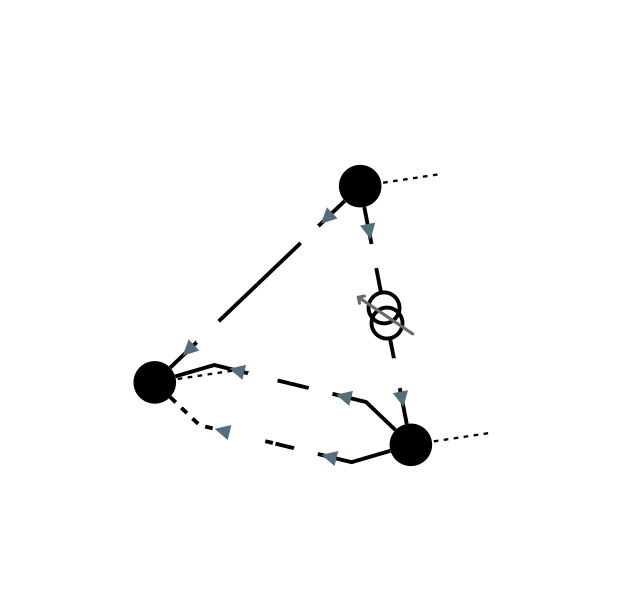

In [4]:
network =  pp.network.load("./data/rao/angle_monitoring/network.xiidm")
network.get_network_area_diagram()

Now, let's run a loadflow on this network. We'll then be able to assess which lines are overloaded.

2025-09-08 17:08:43,722 - INFO - powsybl - loadflow provider used is : OpenLoadFlow
2025-09-08 17:08:43,722 - INFO - powsybl - Version: {repositoryName=powsybl-open-loadflow, mavenProjectVersion=1.16.0, gitVersion=9f4cb68a4139a1a5db7353e4b81ae590377f3096, gitBranch=UNKNOWN, buildTimestamp=2025-07-10T12:40:12.650Z}
2025-09-08 17:08:43,727 - INFO - powsybl - Parameters:
┌───────────────────────────┬───────────────────────────────────────────────────────────┬──────────────────────────────────┐
│ Category                  │ Name                                                      │ Value                            │
├───────────────────────────┼───────────────────────────────────────────────────────────┼──────────────────────────────────┤
│ Automation                │ simulateAutomationSystems                                 │ false                            │
│ DC                        │ dcApproximationType                                       │ IGNORE_R                         │
│   

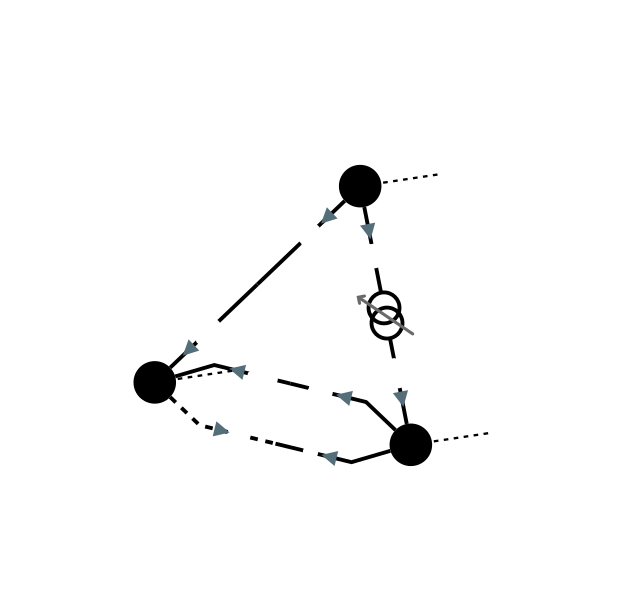

In [5]:
pp.loadflow.run_ac(network)
network.get_network_area_diagram()

The monitoring algorithm is run after a RAO has been run, on a network on which are applied the remedial actions optimized during the RAO to optimize flow CNECs. 
To relieve Angle/Voltage CNECs, we won't be optimizing remedial actions because modelling the impact of remedial actions on angle/voltage values is highly complex and non linear. Instead, we'll be checking application conditions and applying remedial actions until CNECs are relieved.

To run a monitoring, we need to load the following inputs:

In [6]:
parameters = RaoParameters()
parameters.load_from_file_source("./data/rao/rao_parameters.json")
load_flow_parameters = parameters.loadflow_and_sensitivity_parameters.sensitivity_parameters.load_flow_parameters

As stated previously, first we'll run a rao and save the rao_result. This rao_result will be used to load activated remedial actions during the monitoring module.

In [7]:
rao_runner = pp.rao.create_rao()
rao_runner.set_crac_file_source(network, "./data/rao/angle_monitoring/voltage_monitoring_simple_case_with_RA_on_load.json")

In [8]:
rao_result = rao_runner.run(network, parameters)

2025-09-08 17:08:44,081 - WARNING - powsybl - Running RAO using Open RAO version 6.7.0-SNAPSHOT from git commit ea80e63634c4ff2038696d4ca76f99ed861d1263.
2025-09-08 17:08:44,082 - WARNING - powsybl - Non re-optimizing curative range actions is deprecated. Curative range actions re-optimization will be mandatory in a future OpenRAO version.
2025-09-08 17:08:44,082 - WARNING - powsybl - A threshold for the flowCnec cnec1 - preventive is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 17:08:44,082 - WARNING - powsybl - A threshold for the flowCnec cnec1 - curative is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 17:08:44,082 - WARNING - powsybl - A threshold for the flowCnec cnec1 - preventive is defined in MW but the loadflow computation is in AC. It wil

In this case, no remedial actions were applied during the RAO, the network was already secure.



Before running the angle monitoring algorithm, let's look at the voltage cnec's situation in the network. As you can see in the crac, VoltageCnec vc is defined on VL2, at curative instant after contingency coL1 that disconnects PST PS1. A minimum threshold is defined at 340 kV, a maximum threshold at 350 kV. Let's look at the network after disconnecting PS1:

2025-09-08 17:08:44,407 - INFO - powsybl - loadflow provider used is : OpenLoadFlow
2025-09-08 17:08:44,407 - INFO - powsybl - Version: {repositoryName=powsybl-open-loadflow, mavenProjectVersion=1.16.0, gitVersion=9f4cb68a4139a1a5db7353e4b81ae590377f3096, gitBranch=UNKNOWN, buildTimestamp=2025-07-10T12:40:12.650Z}
2025-09-08 17:08:44,411 - INFO - powsybl - Parameters:
┌───────────────────────────┬───────────────────────────────────────────────────────────┬──────────────────────────────────┐
│ Category                  │ Name                                                      │ Value                            │
├───────────────────────────┼───────────────────────────────────────────────────────────┼──────────────────────────────────┤
│ Automation                │ simulateAutomationSystems                                 │ false                            │
│ DC                        │ dcApproximationType                                       │ IGNORE_R                         │
│   

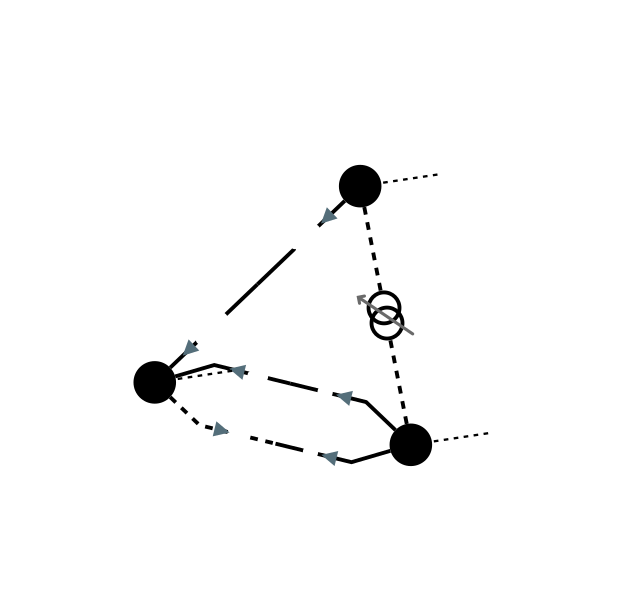

In [9]:
network.disconnect("PS1")
pp.loadflow.run_ac(network)
network.get_network_area_diagram()

VoltageCnec vc is unsecure with a voltage of 368 kV > 350 kV.
Now let's run the voltage monitoring algorithm.

In [10]:
result_with_voltage_monitoring = rao_runner.run_voltage_monitoring(network, rao_result, load_flow_parameters, "OpenLoadFlow")
df_voltage_cnecs = result_with_voltage_monitoring.get_voltage_cnec_results()
print(df_voltage_cnecs[['cnec_id', 'min_voltage', 'max_voltage', 'margin']])
print(result_with_voltage_monitoring.to_json())

2025-09-08 17:08:44,531 - INFO - powsybl - ----- VOLTAGE monitoring [start]
2025-09-08 17:08:44,532 - INFO - powsybl - -- 'VOLTAGE' Monitoring at state 'preventive' [start]
2025-09-08 17:08:44,532 - INFO - powsybl - Load-flow computation [start]
2025-09-08 17:08:44,532 - INFO - powsybl - Version: {repositoryName=powsybl-open-loadflow, mavenProjectVersion=1.16.0, gitVersion=9f4cb68a4139a1a5db7353e4b81ae590377f3096, gitBranch=UNKNOWN, buildTimestamp=2025-07-10T12:40:12.650Z}
2025-09-08 17:08:44,538 - INFO - powsybl - Parameters:
┌───────────────────────────┬───────────────────────────────────────────────────────────┬────────────────────────────────┐
│ Category                  │ Name                                                      │ Value                          │
├───────────────────────────┼───────────────────────────────────────────────────────────┼────────────────────────────────┤
│ Automation                │ simulateAutomationSystems                                 │ false   

      cnec_id  min_voltage  max_voltage     margin
index                                             
0          vc   363.622121   363.622121 -13.622121
{'type': 'RAO_RESULT', 'version': '1.8', 'info': 'Generated by Open RAO https://powsybl.readthedocs.io/projects/openrao', 'computationStatus': 'default', 'executionDetails': 'The RAO only went through first preventive', 'costResults': {'initial': {'functionalCost': 95.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}, 'preventive': {'functionalCost': 95.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}, 'outage': {'functionalCost': 95.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}, 'auto': {'functionalCost': 95.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}, 'curative': {'functionalCost': 95.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}}, 'computationStatusMap': [], 'flowCnecResults': [{'flowCnecId': 'cnec1 - curative', 'initial': {'ampere': {'margin': 1.7976931348623157e+308, 'side2': {'flow': 175.35}}, 'megaw